Tic Tac Toe Spielstanderkenner

Ziel dieser Arbeit ist es, dass Bilder eines Tic Tac Toe Spiels eingegeben werden und der Spielstand automatisch erkannt wird. Wenn es einen Gewinner gibt, soll dieser Markiert und ausgegeben werden

Schritt 1 Bilder einlesen

Gefundene O’s (x, y, r): [(np.int64(1664), np.int64(529), np.int64(30)), (np.int64(1657), np.int64(512), np.int64(30)), (np.int64(1516), np.int64(290), np.int64(30)), (np.int64(1521), np.int64(279), np.int64(30)), (np.int64(1529), np.int64(268), np.int64(30)), (np.int64(1622), np.int64(428), np.int64(30)), (np.int64(1610), np.int64(385), np.int64(30)), (np.int64(1543), np.int64(382), np.int64(30)), (np.int64(1576), np.int64(376), np.int64(30)), (np.int64(1559), np.int64(374), np.int64(30))]
Gefundene X’s (x, y): []


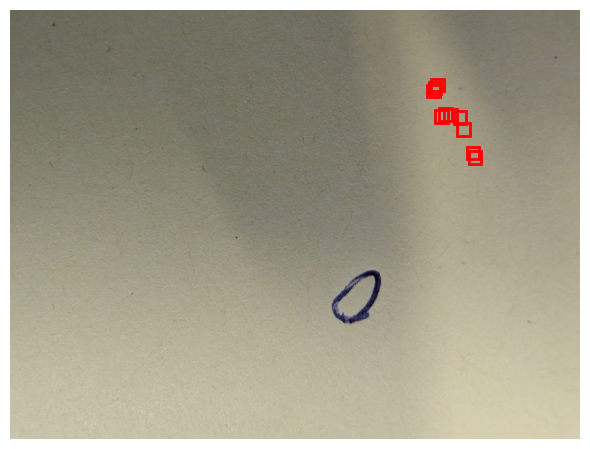

In [22]:
import numpy as np
from skimage import io, color, filters, morphology, feature, transform
from skimage.transform import hough_circle, hough_circle_peaks, probabilistic_hough_line
import math
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

# --- 1. Vorverarbeitung ---
def load_and_preprocess(path, sigma=1.0, min_size=150):
    img = io.imread(path)
    # --- Alpha-Kanal entfernen, falls vorhanden ---
    if img.ndim == 3 and img.shape[2] == 4:
        # Variante A: einfach Alpha wegwerfen
        img = img[..., :3]
        # Oder Variante B: korrekt mischen
        # from skimage.color import rgba2rgb
        # img = rgba2rgb(img)

    # in Float [0,1] umwandeln
    img = img / 255.0 if img.dtype != np.float64 else img

    # Graustufen
    gray = color.rgb2gray(img)
    # Rest wie gehabt
    blurred = filters.gaussian(gray, sigma=sigma)
    thresh  = filters.threshold_otsu(blurred)
    binary  = blurred > thresh
    clean   = morphology.remove_small_objects(binary, min_size=min_size)
    return img, clean

# --- 2. O-Erkennung via HoughCircles ---
def detect_Os(binary, radii_range=(20,50,2), total_peaks=10):
    radii = np.arange(*radii_range)
    hough_res = hough_circle(binary, radii)
    accums, cx, cy, rad = hough_circle_peaks(
        hough_res, radii,
        total_num_peaks=total_peaks,
        min_xdistance=int(radii_range[0]/2),
        min_ydistance=int(radii_range[0]/2)
    )
    # Rückgabe: Liste von (x_center, y_center, radius)
    return list(zip(cx, cy, rad))

# --- 3. X-Erkennung via gekreuzte Linien ---
def detect_Xs(binary, line_length=50, line_gap=3, angle_tol=15):
    edges = feature.canny(binary, sigma=2)
    lines = probabilistic_hough_line(edges,
                                     threshold=10,
                                     line_length=line_length,
                                     line_gap=line_gap)

    pos, neg = [], []
    for (p0, p1) in lines:
        dy, dx = (p1[1]-p0[1], p1[0]-p0[0])
        angle = math.degrees(math.atan2(dy, dx))
        if angle > 90: angle -= 180
        if abs(angle - 45) < angle_tol:
            pos.append((p0,p1))
        elif abs(angle + 45) < angle_tol:
            neg.append((p0,p1))

    crosses = []
    for l1 in pos:
        for l2 in neg:
            (x1,y1),(x2,y2) = l1
            (x3,y3),(x4,y4) = l2
            denom = (x1-x2)*(y3-y4) - (y1-y2)*(x3-x4)
            if denom == 0: continue
            px = ((x1*y2 - y1*x2)*(x3-x4) - (x1-x2)*(x3*y4 - y3*x4)) / denom
            py = ((x1*y2 - y1*x2)*(y3-y4) - (y1-y2)*(x3*y4 - y3*x4)) / denom
            crosses.append((px, py))
    # Rückgabe: Liste von (x_cross, y_cross)
    return crosses

# --- 4. Zusammenspiel und Darstellung ---
def detect_and_draw(path):
    img, binary = load_and_preprocess(path)
    circles = detect_Os(binary)
    crosses = detect_Xs(binary)

    # Ergebnis-Liste ausgeben
    print("Gefundene O’s (x, y, r):", circles)
    print("Gefundene X’s (x, y):", crosses)

    # Visualisierung
    fig, ax = plt.subplots(1,1, figsize=(6,6))
    ax.imshow(img)
    ax.set_axis_off()

    # 5. Bounding Boxes zeichnen
    # Für O: Quadrat um Kreis
    for (x,y,r) in circles:
        side = r*1.5  # etwas größer als Durchmesser
        rect = Rectangle(
            (x-side/2, y-side/2),   # linke obere Ecke
            side, side,             # Breite, Höhe
            linewidth=2,
            edgecolor='red',
            facecolor='none'
        )
        ax.add_patch(rect)

    # Für X: fixen Box-Size um Kreuz-Mittelpunkt
    box_size = 40
    for (x,y) in crosses:
        rect = Rectangle(
            (x-box_size/2, y-box_size/2),
            box_size, box_size,
            linewidth=2,
            edgecolor='red',
            facecolor='none'
        )
        ax.add_patch(rect)

    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    detect_and_draw("O_1.png")

Schritt zwei Processing Pipeline je Bild

Schleife für alle Bilder

In [ ]:
results = {}
for path in paths:
    try:
        grid = process_image(path)
        results[os.path.basename(path)] = grid
        print(f"{os.path.basename(path)} → {grid}")
    except Exception as e:
        print(f"Fehler bei {path}: {e}")


Mögliche Vorschläge:

4. Empfehlungen
Modularisieren: Packt jede Funktion in ein eigenes Modul (preprocess.py, grid.py, warp.py, recognition.py), dann importiert ihr sie in main.py.

Parameter-Tuning: Führt Tests mit verschiedenen sigma, min_size und Hough-Schwellen durch und protokolliert, was am besten funktioniert.

Fehlerbehandlung: Wenn find_grid mal nicht genügend Linien findet, überspringt das Bild oder versucht einen alternativen Ansatz (z. B. Kanten-Dilatation).

Batch-Logging: Schreibt in eine Log-Datei, welche Bilder erfolgreich geprocessed wurden und welche fehlschlugen.